<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/NER-and-POS-tagging/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the project:
---
Named Entity Recognition (NER): map words to different types (tags)

# Load the dataset:

In [ ]:
# install libraries:
!pip install transformers datasets
# `transformers` library: for working with pre-trained NLP models
# `datasets` library: for working with datasets

In [ ]:
# from `datasets` library, import the `load_dataset` func for downloading datasets
from datasets import load_dataset

In [ ]:
# use the `load_dataset` func to load the CoNLL-2003 dataset (a popular benchmark dataset for NER consists of English news articles):
data = load_dataset("conll2003")

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
# check features (cols) of the train data:
data["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [ ]:
# check a specific feature:
data["train"].features['ner_tags']

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [ ]:
# check different types of named entities & save the tags for later:
label_names = data["train"].features['ner_tags'].feature.names

# Load the tokenizer:

In [ ]:
from transformers import AutoTokenizer # import the 'AutoTokenizer' class from the HF transformers library
# `AutoTokenizer` class: automatically load the appropriate tokenizer for a specific pre-trained model

checkpoint = "distilbert-base-cased" # model identifier (specify the name of a pre-trained model)
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # automatically load the appropriate tokenizer

# The input:

In [ ]:
# check the 1st row in the training split of the dataset:
data["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
# tokenize the 'tokens' feature of the 1st row in the training split of the dataset:
idx = 0
t = tokenizer(data["train"][idx]["tokens"], is_split_into_words=True)
# `is_split_into_words=True`: string input -> a list of words (string tokens) -> tokenize each word into a numeric token
t

{'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

👆 The attention_mask is a binary mask that indicates which tokens in a sequence should be attended to (considered) and which should be ignored during processing.

The primary purpose of the attention_mask is to handle variable-length sequences. In a batch of sequences, not all sequences are likely to have the same length. The attention_mask allows the model to focus on the actual content of the sequence and ignore the padding tokens.

In many tokenization scenarios, padding tokens are added to the sequences to make them of equal length.

In [ ]:
type(t)

transformers.tokenization_utils_base.BatchEncoding

👆 The tokenized output is a BatchEncoding object (a dictionary with specific keys).

In [ ]:
# get string tokens:
t.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

👆 The word "lamb" has been split into ***2 subwords*** ('la' + '##mb').

But we are provided with ***1 target*** for the whole word.

Therefore, the input sequence may end up being longer than the target sequence!

Solution: ***For any word split into multiple string tokens, we assign the same target***. Eg: 'la' -> 7, '##mb' -> 7

# Align string tokens (subwords) to targets correctly:

eg:
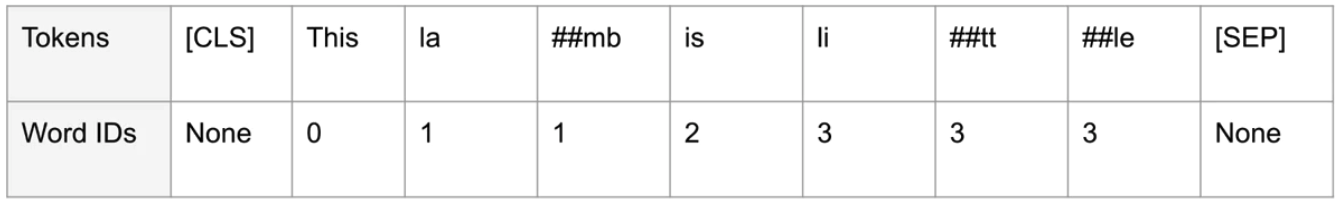

In [ ]:
# word_id (i) indicates it is the i-th word in the input sentence (counting from 0):
t.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

👆 The targets are None for [CLS] and [SEP] tokens. And 8 responses to the period.

In [ ]:
# map NER begin tags to inside tags using idx:
begin2inside = {
  #  idx:   0    1        2        3        4        5        6        7         8
  # tags: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
  1: 2, # 'B-PER', 'I-PER' (label 1 map to label 2)
  3: 4, # 'B-ORG', 'I-ORG' (label 3 map to label 4)
  5: 6, # 'B-LOC', 'I-LOC'
  7: 8, # 'B-MISC','I-MISC'
}

👆 This takes care of 4 types of entities (PER, ORG, LOC, MISC).

In [ ]:
def align_targets(labels, word_ids):
  aligned_labels = []
  last_id = None
  for id in word_ids:
    if id is None: # [CLS] or [SEP]
      label = -100
    elif id != last_id: # it's a new id (for a new word)
      label = labels[id]
    else: # it's the same word as before
      label = labels[id]
      if label in begin2inside: # B-tag
        label = begin2inside[label] # B-tag -> I-tag

    aligned_labels.append(label)
    last_id = id # update last_id to be the current id

  return aligned_labels # eg: [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]

In [ ]:
# scratch:
# idx = 0  # defined earlier
data['train'][idx]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
# arguments for the func:
labels = data['train'][idx]['ner_tags'] # [3, 0, 7, 0, 0, 0, 7, 0, 0]
word_ids = t.word_ids() # [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

# call the 'align_targets' func:
aligned_targets = align_targets(labels, word_ids)
aligned_targets

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]

👆 a list starts and ends with -100

In [ ]:
# scratch:
# get string tokens:
t.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [ ]:
# scratch:
# check different types of named entities & save the tags for later:
label_names = data["train"].features['ner_tags'].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [ ]:
#  idx:   0    1        2        3        4        5        6        7         8
# tags: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

#   aligned_targets: [-100,  3,       0,  7,         0,   0,   0,   7,        0,   0,   0,  -100]
# -> aligned_labels: [None, 'B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', None]
aligned_labels = [label_names[t] if t >= 0 else None for t in aligned_targets]
print(aligned_labels, "\n")

# (subword) string token <-> tag:
for x, y in zip(t.tokens(), aligned_labels):
  print(f"{x}\t{y}")

[None, 'B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', None] 

[CLS]	None
EU	B-ORG
rejects	O
German	B-MISC
call	O
to	O
boycott	O
British	B-MISC
la	O
##mb	O
.	O
[SEP]	None


👆 The 'O' tags are less informative.

I want to see whether B-tags get correctly transformed into I-tags.

In [ ]:
# make up a fake input:
words = [
  '[CLS]', 'Ger', '##man', 'call', 'to', 'boycott', 'Micro', '##soft', '[SEP]'] # intentionally split the word

#  idx:   0    1        2        3        4        5        6        7         8
# tags: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
# MISC: miscellaneous category (entities that do not fit into 'PER' or 'ORG' or `LOC')
# arguments:
labels = [7, 0, 0, 0, 3] # idx for the corresponding tag
word_ids = [None, 0, 0, 1, 2, 3, 4, 4, None] # i-th word

# call the func:
aligned_targets = align_targets(labels, word_ids)
print(aligned_targets, "\n") # [-100, 7, 8, 0, 0, 0, 3, 4, -100]

aligned_labels = [label_names[t] if t >= 0 else None for t in aligned_targets]
for x, y in zip(words, aligned_labels):
  print(f"{x}\t{y}")

[-100, 7, 8, 0, 0, 0, 3, 4, -100] 

[CLS]	None
Ger	B-MISC
##man	I-MISC
call	O
to	O
boycott	O
Micro	B-ORG
##soft	I-ORG
[SEP]	None


In [ ]:
# tokenize function wrapper that tokenize both inputs and targets:
def tokenize_fn(batch):
  # tokenize the input sequence first, this populates input_ids, attention_mask, etc
  tokenized_inputs = tokenizer(
    batch['tokens'], truncation=True, is_split_into_words=True
  )
  print("👀tokenized_inputs:", tokenized_inputs)

  labels_batch = batch['ner_tags'] # original targets
  aligned_labels_batch = []
  for i, labels in enumerate(labels_batch):
    word_ids = tokenized_inputs.word_ids(i)
    aligned_labels_batch.append(align_targets(labels, word_ids))

  # recall: the 'target' must be stored in key called 'labels'
  tokenized_inputs['labels'] = aligned_labels_batch

  return tokenized_inputs

In [ ]:
# check existing col names:
data["train"].column_names

['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']

In [ ]:
# tokenize exitsting cols:
tokenized_datasets = data.map(
  tokenize_fn,
  batched=True, # the tokenization function should be applied in batches rather than individually on each example
  remove_columns=data["train"].column_names,
)

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

👀tokenized_inputs: {'input_ids': [[101, 15531, 9741, 22441, 1942, 118, 149, 27514, 10954, 9272, 9637, 1708, 3048, 18172, 2036, 157, 1592, 22441, 152, 17145, 2069, 13020, 16972, 2101, 138, 26321, 9637, 15969, 27451, 11780, 1708, 7118, 16647, 9565, 3663, 119, 102], [101, 149, 11414, 2137, 11414, 1820, 118, 4775, 118, 1476, 102], [101, 1537, 1890, 1155, 118, 1668, 1200, 5676, 14068, 1261, 1300, 1111, 3383, 1113, 5286, 1112, 21854, 3222, 8860, 1118, 1126, 6687, 1105, 3614, 2326, 1107, 1160, 1552, 1106, 1321, 1166, 1120, 1103, 1246, 1104, 1103, 2514, 2899, 119, 102], [101, 2397, 2215, 1113, 1499, 117, 1463, 117, 1336, 1129, 1603, 118, 2077, 1112, 1641, 9521, 8493, 117, 15964, 1105, 9757, 1155, 1804, 1107, 1113, 2681, 1229, 5327, 1189, 1146, 1111, 1575, 1159, 1107, 1147, 4458, 118, 4634, 1801, 1222, 21942, 119, 102], [101, 1258, 11518, 8860, 1149, 1111, 6032, 1113, 1103, 2280, 2106, 1120, 4378, 1914, 117, 21854, 2925, 1147, 1148, 6687, 1118, 5706, 2326, 1196, 1217, 21663, 1149, 1111, 1853, 1

In [ ]:
# check the result:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

👆 Each data has 3 featrues ('input_ids', 'attention_mask', and 'labels').

# Data collator for token classification:
Organize and collate data, ensuring that the data is appropriately grouped into batches for training or other purposes.

In [ ]:
from transformers import DataCollatorForTokenClassification # import the class to classify individual tokens in a sequence

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer) # create an instance of the class

In [ ]:
# grab the first 2 samples from the 'tokenized_datasets':
tokenized_datasets["train"][:2]

{'input_ids': [[101,
   7270,
   22961,
   1528,
   1840,
   1106,
   21423,
   1418,
   2495,
   12913,
   119,
   102],
  [101, 1943, 14428, 102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1]],
 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100], [-100, 1, 2, -100]]}

👆 One dictionary that holds all selected samples (a dict of lists of lists).

Unfortunately, this is not the format a data collator can work with.

In [ ]:
[tokenized_datasets["train"][i] for i in range(2)]

[{'input_ids': [101,
   7270,
   22961,
   1528,
   1840,
   1106,
   21423,
   1418,
   2495,
   12913,
   119,
   102],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]},
 {'input_ids': [101, 1943, 14428, 102],
  'attention_mask': [1, 1, 1, 1],
  'labels': [-100, 1, 2, -100]}]

👆 Grab each sample individually (a list of dictionaries, with each dict corresponds to a sample).

In [ ]:
# example case:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print(batch, "\n")
batch["labels"]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])} 



tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

👆 `batch["labels"]` is a PyTorch tensor

-100 for all the tokens we don't care about the output ([CLS], [SEP], and padding tokens)

# Metrics:

In [ ]:
# install the 'seqeval' package for sequence labeling evaluation:
!pip install seqeval

In [ ]:
from datasets import load_metric # from 'datasets' lib, import the 'load_metric' func to load predefined eval metrics

metric = load_metric("seqeval") # load the metric associated with the sequence labeling task ("seqeval" is a task identifier)

<ipython-input-31-79625d9c3e87>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval") # load the metric associated with the sequence labeling task ("seqeval" is a task identifier)


In [ ]:
# dummy test - list of lists:
metric.compute(
    predictions=[[0], [0], [0]],
    references=[[0], [0], [1]])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.6666666666666666}

In [ ]:
# dummy test - list containing a single list:
metric.compute(
    predictions=[[0, 0, 0]],
    references=[[0, 0, 1]])

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.6666666666666666}

In [ ]:
# dummy test - list containing a single list of string labels:
metric.compute(
    predictions=[['A', 'A', 'A']],
    references=[['A', 'B', 'A']])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: A seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.6666666666666666}

In [ ]:
# dummy test - list containing a single list of IBO tags:
metric.compute(
    predictions=[['O', 'O', 'I-ORG', 'B-MISC']],
    references=[['O', 'B-ORG', 'I-ORG', 'B-MISC']])

{'MISC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.5,
 'overall_recall': 0.5,
 'overall_f1': 0.5,
 'overall_accuracy': 0.75}

👆 We got not only the overall metrics for accuracy (overall accuracy, precision, F1, recall),

but we also got metrics on the per entity basis (accuracy, precision, F1, recall for 'MISC' and 'ORG').

In [ ]:
import numpy as np #  import the NumPy library for numerical computations in Python

def compute_metrics(logits_and_labels): # take in a duple as the input
  logits, labels = logits_and_labels # unpack the tuple
  preds = np.argmax(logits, axis=-1) # compute the predictions by taking the index of the maximum logit along the last axis

  # remove -100 from labels & convert label_ids to label names:
  str_labels = [
    [label_names[t] for t in label if t != -100] for label in labels
  ]

  # do the same for predictions:
  str_preds = [
    [label_names[p] for p, t in zip(pred, targ) if t != -100] \
      for pred, targ in zip(preds, labels)
  ]

  the_metrics = metric.compute(predictions=str_preds, references=str_labels)

  # return the overall metrics (in a new dictionary) with more concise names:
  return {
    'precision': the_metrics['overall_precision'],
    'recall': the_metrics['overall_recall'],
    'f1': the_metrics['overall_f1'],
    'accuracy': the_metrics['overall_accuracy'],
  }

# Fine-tuning the model:

In [ ]:
# ensure consistency between the model's output indices and the human-readable label names:

# map from indices to label names:
id2label = {k: v for k, v in enumerate(label_names)} # {id: label_name, ...}

# map from label name to indices:
label2id = {v: k for k, v in id2label.items()} # {label_name: id, ...}

In [ ]:
from transformers import AutoModelForTokenClassification # from transformers lib import the class to assign a label to each token in a seq

# load a pre-trained model for token classification using the HF transformers library:
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint, # identifier to the pre-trained
    # the mappings help the model understand how to map between indices and label names:
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch] # the PyTorch version of the 'transformers' library is installed

In [ ]:
from transformers import TrainingArguments # (import the class) for configuring and customizing the training process

training_args = TrainingArguments(
    "distilbert-finetuned-ner", # directory for saving model checkpoints and results
    evaluation_strategy="epoch", # evaluate and save results after each epoch
    save_strategy="epoch", # save model checkpoints after each epoch
    learning_rate=2e-5, # lr for training the model
    num_train_epochs=3,
    weight_decay=0.01, # weight decay to apply during training
)

In [ ]:
from transformers import Trainer # (class) for training models

# create a class instance:
trainer = Trainer(
    model=model, # the pre-trained model to train
    args=training_args, # training arguments
    train_dataset=tokenized_datasets["train"], # training dataset (tokenized) for token classification tasks
    eval_dataset=tokenized_datasets["validation"], # evaluation dataset (tokenized) to assess the model's performance during training
    data_collator=data_collator, # for batching and collating the tokenized data during training
    compute_metrics=compute_metrics, # specify the function (compute_metrics) for evaluating and computing metrics on the validation set during training
    tokenizer=tokenizer, # the tokenizer to tokenize the input data
)

# train() method is called on the trainer object to initiate the training process:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.097300,0.089211,0.879633,0.918714,0.898749,0.974937


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.097300,0.089211,0.879633,0.918714,0.898749,0.974937


# Save the fine-tuned model & reload as pipeline:

In [ ]:
# save the trained model, including its architecture and learned parameters, to a specified directory:
trainer.save_model('my_saved_model')

In [ ]:
from transformers import pipeline # import the 'pipeline' function use pre-trained models

# create a NER pipeline:
ner = pipeline(
  "token-classification", # specify the pipeline task
  model='my_saved_model', # path to the saved model for NER
  aggregation_strategy="simple", # combine tokens to recognize the entities (combine "John" and "Doe" to PER, and "Google" to ORG).
  device=0, # use GPU for inference
)

In [ ]:
# perform NER on an input string:
s = "Bill Gates was the CEO of Microsoft in Seattle, Washington."
ner(s)

🎉 The model correctly tells that

"Bill Gates" is a PER entity,

"Microsoft" is a ORG entity,

"Seattle" and "Washington" are both "LOC" entities.